0.6148356538342095
0.5000000000000001
0.5825


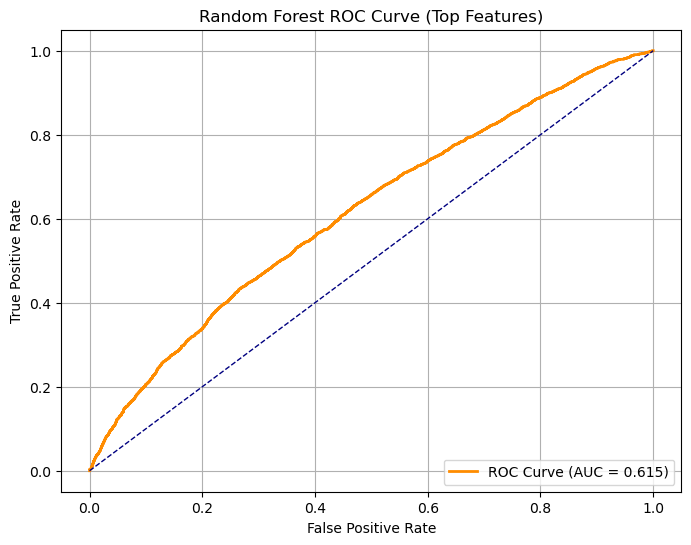

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score

IMPORTANT_FEATURES = [
    'age', 'avg_daily_uv', 'sunscreen_spf', 'sunscreen_freq', 
    'lesion_size_mm', 'lesion_color', 'number_of_lesions',
    'family_history', 'immunosuppressed', 'sunburns_last_year',
    'years_lived_at_address', 'occupation'
]

train_raw = pd.read_csv('SkinCancerTrain.csv')
test_raw = pd.read_csv('SkinCancerTestNoY.csv')

train_raw['is_train'] = True
test_raw['is_train'] = False
test_raw['Cancer'] = np.nan  # used as a placeholder for consistency

df = pd.concat([train_raw, test_raw], axis=0).reset_index(drop=True)
cols_to_keep = IMPORTANT_FEATURES + ['ID', 'Cancer', 'is_train']
df = df[cols_to_keep]

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ['is_train']]  

for col in numeric_cols:
    if df[col].isnull().any():
        df[f'{col}_missing_flag'] = df[col].isnull().astype(int)
        df[col] = df[col].fillna(df[col].median())

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [c for c in categorical_cols if c not in ['ID', 'Cancer']]

for col in categorical_cols:
    df[col] = df[col].fillna("Unknown")

df_encoded = pd.get_dummies(df, columns=categorical_cols, dummy_na=False)
df_encoded['target'] = df_encoded['Cancer'].apply(lambda x: 1 if x == 'Malignant' else (0 if x == 'Benign' else np.nan))

feature_cols = [c for c in df_encoded.columns if c not in ['ID', 'Cancer', 'target', 'is_train']]

X_full = df_encoded[df_encoded['is_train'] == True][feature_cols].astype(float)
y_full = df_encoded[df_encoded['is_train'] == True]['target'].values
X_test_submission = df_encoded[df_encoded['is_train'] == False][feature_cols].astype(float)

X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

rf = RandomForestClassifier(
    n_estimators=800, max_depth=10,
    min_samples_split=5, min_samples_leaf=3,
    max_features='sqrt', bootstrap=True,
    random_state=42, n_jobs=-1
)

rf.fit(X_train, y_train)

probabilityrf = rf.predict_proba(X_val)[:, 1]
auc_rf = roc_auc_score(y_val, probabilityrf)
print(auc_rf) #rf

thresholdrf = 0.50
accuracyrf = 0
for threshold in np.arange(0.40, 0.60, 0.01):
    preds = (probabilityrf > threshold).astype(int)
    acc = accuracy_score(y_val, preds)
    if acc > accuracyrf:
        accuracyrf = acc
        thresholdrf = threshold

print(thresholdrf) #threshold
print(accuracyrf) #accuracy

finalrf = RandomForestClassifier(
    n_estimators=800, max_depth=10,
    min_samples_split=5, min_samples_leaf=3,
    max_features='sqrt', bootstrap=True,
    random_state=42, n_jobs=-1
)
finalrf.fit(X_full, y_full)

probabilityrf_final = finalrf.predict_proba(X_test_submission)[:, 1]
predictionrf_final = np.where(probabilityrf_final > thresholdrf, "Malignant", "Benign")

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

probabilities = rf.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"(AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1])  
plt.title("Random Forest ROC Curve (Top Features)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

submissionrf = pd.DataFrame({
    'ID': test_raw['ID'],
    'Cancer': predictionrf_final
})
submissionrf.to_csv('rf_finalsubmission_importantvars.csv', index=False)